In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as img
from sklearn.metrics import f1_score 
import tensorflow as tf
import pathlib
import random

In [34]:
df_train = pd.read_csv('/kaggle/input/automatic-classification-of-fetal-ultrasound-brain/train.csv')
df_test = pd.read_csv('/kaggle/input/automatic-classification-of-fetal-ultrasound-brain/test.csv')
submission = pd.read_csv('/kaggle/input/automatic-classification-of-fetal-ultrasound-brain/sample_submission.csv')

IMAGE_SIZE = (256, 256, 1)

data_dir = pathlib.Path('/kaggle/input/automatic-classification-of-fetal-ultrasound-brain/data/data/')



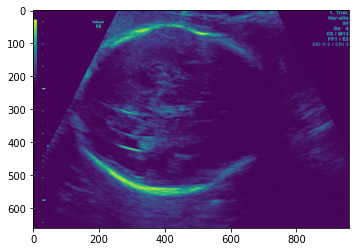

In [35]:
image = img.imread(data_path+'/'+df_train.iloc[random.randint(0, len(df_train)),0]+'.png')
plt.imshow(image)

In [37]:
df_train['image_name'] = df_train['image_name'].apply(lambda x : x + '.png' )
df_test['image_name'] = df_test['image_name'].apply(lambda x : x + '.png' )

In [38]:
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2,shear_range=0.2,
                                       rotation_range=20,
                                       brightness_range=[0.4,1.5])

In [9]:
train_ds = datagen.flow_from_dataframe(dataframe=df_train,
                                       directory=data_dir,
                                       x_col = 'image_name',
                                       y_col = 'class',
                                       subset='training',
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       seed=43,
                                       target_size=IMAGE_SIZE[:-1],
                                       batch_size=32)

valid_ds = datagen.flow_from_dataframe(dataframe=df_train,
                                       directory=data_dir,
                                       x_col = 'image_name',
                                       y_col = 'class',
                                       subset='validation',
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       seed=43,
                                       target_size=IMAGE_SIZE[:-1],
                                       batch_size=32)
test_ds = datagen.flow_from_dataframe(dataframe=df_test,
                                       directory=data_dir,
                                       x_col = 'image_name',
                                       class_mode=None,
                                       color_mode='rgb',
                                       target_size=IMAGE_SIZE[:-1],
                                       batch_size=32)


Found 2000 validated image filenames belonging to 4 classes.
Found 500 validated image filenames belonging to 4 classes.
Found 592 validated image filenames.


In [10]:
import tensorflow.keras.backend as K

In [11]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
from tensorflow.keras.optimizers import Adam 

In [13]:
model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
        
])

2022-01-19 18:03:31.081370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 18:03:31.204463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 18:03:31.205145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 18:03:31.206321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[get_f1])
history = model.fit(train_ds, epochs=10, batch_size=32, shuffle=True, validation_data=valid_ds)

2022-01-19 18:03:34.484812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-01-19 18:03:36.937090: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 75s 1s/step - loss: 1.2526 - get_f1: 0.3023 - val_loss: 1.0265 - val_get_f1: 0.5348
Epoch 2/10
63/63 [==============================] - 57s 901ms/step - loss: 1.0657 - get_f1: 0.4342 - val_loss: 0.9886 - val_get_f1: 0.5108
Epoch 3/10
63/63 [==============================] - 57s 906ms/step - loss: 0.9930 - get_f1: 0.5014 - val_loss: 0.9748 - val_get_f1: 0.4749
Epoch 4/10
63/63 [==============================] - 58s 917ms/step - loss: 0.9025 - get_f1: 0.5676 - val_loss: 0.9401 - val_get_f1: 0.6172
Epoch 5/10
63/63 [==============================] - 57s 915ms/step - loss: 0.8489 - get_f1: 0.5984 - val_loss: 0.9078 - val_get_f1: 0.5841
Epoch 6/10
63/63 [==============================] - 58s 919ms/step - loss: 0.8107 - get_f1: 0.6335 - val_loss: 0.8926 - val_get_f1: 0.5774
Epoch 7/10
63/63 [==============================] - 57s 912ms/step - loss: 0.7738 - get_f1: 0.6584 - val_loss: 0.9106 - val_get_f1: 0.5934
Epoch 8/10
63/63 [=======================

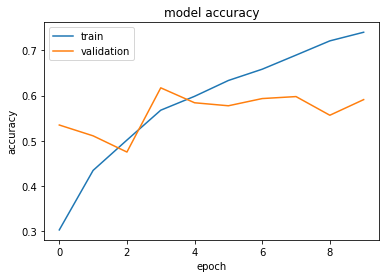

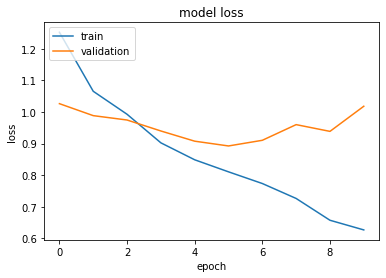

In [42]:
# summarize history for accuracy
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
predictions = model.predict(test_ds).argmax(axis=1)


In [16]:
train_ds.class_indices

{'Other': 0,
 'Trans-cerebellum': 1,
 'Trans-thalamic': 2,
 'Trans-ventricular': 3}

In [18]:
predicted = np.array([train_ds.class_indices.keys()[i] for i in predictions])

In [19]:
submission['class'] = predicted

In [20]:
submission.to_csv('submission.csv', index=False)